In [1]:
import os
import sys
import numpy as np
from pathlib import Path
from time import time
import pickle
import logging
from astropy.table import Table
import orpheus
from matplotlib import pyplot as plt

In [7]:
nbar = 8
len_1 = 600.
len_2 = 600.
ngal = int(nbar*len_1*len_2)
nbinsz = 5
sigma_eps_comp = 0.25
pos1 = len_1*np.random.rand(ngal)
pos2 = len_2*np.random.rand(ngal)
shape1 = np.random.normal(loc=0,scale=sigma_eps_comp,size=ngal)
shape2 = np.random.normal(loc=0,scale=sigma_eps_comp,size=ngal)
zbins = np.random.randint(0,nbinsz,ngal)    
print(ngal)

2880000


In [3]:
cat = orpheus.Catalog(pos1=pos1, pos2=pos2, zbins=zbins)
scat = orpheus.SpinTracerCatalog(spin=2, pos1=pos1, pos2=pos2, tracer_1=shape1, tracer_2=shape2, zbins=zbins)

In [4]:
fields = [shape1 + 1J*shape2]
dpix = .5
tomo=False

In [5]:
%%time
cat_red, fields_red = cat._reduce(fields=fields, dpix=dpix, tomo=tomo, normed=False, ret_inst=True)

CPU times: user 855 ms, sys: 136 ms, total: 991 ms
Wall time: 989 ms


In [6]:
print(np.sum(cat.weight))
print(np.sum(cat_red.weight))

2880000.0
2880000.0


In [7]:
dpixs = [0.25,0.5,1.]
res = scat.multihash(dpixs=dpixs,tomo=False)
(ngals, pos1s, pos2s, weights, zbins, allfields, index_matchers, pixs_galind_bounds, pix_gals) = res

6.221814550233518e-05 2.0084856577895494e-05 599.9998686301852 599.9993385455788
-1.9999377818544977 -1.999979915143422 601.9998686301852 601.9993385455788
603 603 1.0016580537513096 1.0016572445451446
0.25 2880000
0.00026453661940983864 2.0084856577895494e-05 599.9998686301852 599.9989392202165
-1.9999377818544977 -1.999979915143422 601.9998686301852 601.9993385455788
603 603 1.0016580537513096 1.0016572445451446
0.5 2880000
0.0009958644966667762 0.00209136971660584 599.999833416028 599.9989392202165
-1.9999377818544977 -1.999979915143422 601.9998686301852 601.9993385455788
603 603 1.0016580537513096 1.0016572445451446
1.0 2880000
0.17542465683886288 0.12543432913630914 599.842383091805 599.8788950315511
-1.9999377818544977 -1.999979915143422 601.9998686301852 601.9993385455788
603 603 1.0016580537513096 1.0016572445451446


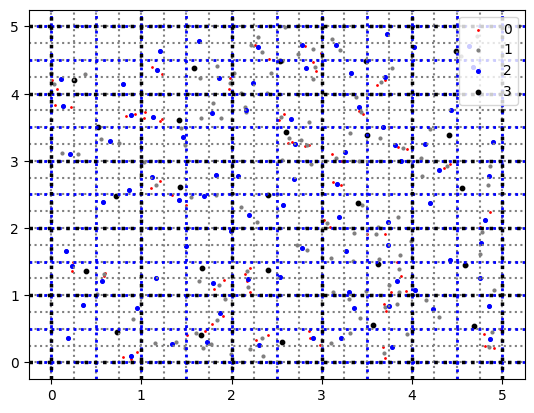

In [8]:
_1 = 5
_2 = 5
elz = 0
dpix_h = 2.
colors = ["red", "grey","blue","black"]
for elreso in range(len(ngals)):
    color=colors[elreso]#"grey"
    if elreso==len(ngals)-1:color="black"
    sel = (zbins[elreso]==elz) * (pos1s[elreso]<_1) * (pos2s[elreso]<_2)
    plt.scatter(pos1s[elreso][sel],pos2s[elreso][sel],color=color,s=1+3*elreso,label=elreso)
    if elreso>0:
        for i in range(int((_1)//dpixs[elreso-1])+1):
            plt.axhline(i*dpixs[elreso-1],color=color,ls=":",lw=1+.5*elreso)
            plt.axvline(i*dpixs[elreso-1],color=color,ls=":",lw=1+.5*elreso)
plt.legend(loc="upper right")
#plt.hist(w_red)

In [9]:
for elres in range(4):
    print(ngals, len(pos1s[elres]), len(index_matchers[elres]), len(pixs_galind_bounds[elres]), len(pix_gals[elres]))

[2880000, 2265754, 1245509, 359886] 2880000 363609 2880001 2880000
[2880000, 2265754, 1245509, 359886] 2265754 363609 2265755 2265754
[2880000, 2265754, 1245509, 359886] 1245509 363609 1245510 1245509
[2880000, 2265754, 1245509, 359886] 359886 363609 359887 359886


In [10]:
n_cfs = 4
min_sep = 80.
max_sep = 320.
nbinsr = 50

threepcf = orpheus.GGGCorrelation(n_cfs, min_sep, max_sep, binsize=.1,method="Discrete")

[2 2 2]
Do we add
We add


In [18]:
redscat = scat.reduce(4., ret_inst=True)
redscat.build_spatialhash(dpix=2.76)

1.7103460967196886 1.76304020216369 598.2751854958276 598.2481295850262
-1.0496539032803112 -0.9969597978363098 601.0351854958276 601.0081295850262
218 218 2.7618570614637976 2.7614912357012042


In [19]:
%%time
threeres = threepcf.process(redscat, nthreads=16)

CPU times: user 3min 14s, sys: 259 ms, total: 3min 15s
Wall time: 15.7 s


In [20]:
%%time
threepcf.multipoles2npcf()

CPU times: user 337 ms, sys: 4 ms, total: 341 ms
Wall time: 337 ms


In [22]:
threepcf.projectnpcf("Centroid")

In [21]:
threepcf.projection

'X'

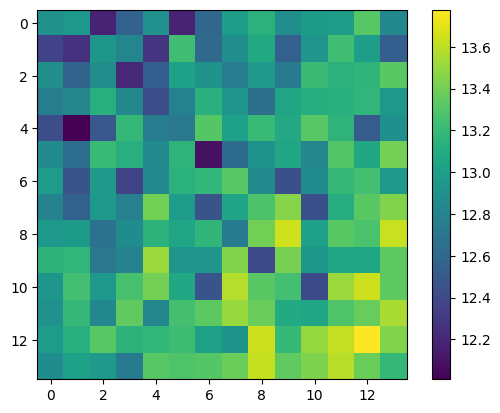

In [17]:
plt.imshow(np.log10(np.abs(threepcf.npcf_multipoles[3,0,0])))
plt.colorbar()

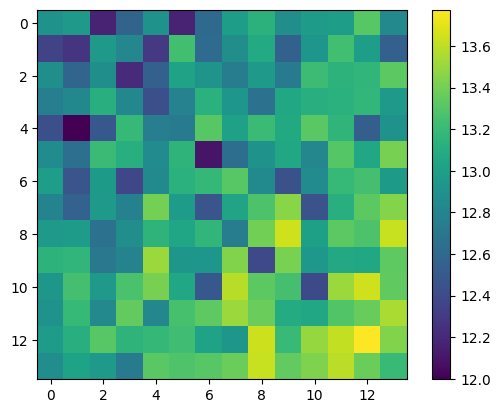

In [23]:
plt.imshow(np.log10(np.abs(threepcf.npcf_multipoles[3,0,0])))
plt.colorbar()

In [24]:
threepcf._gen_npcfprojections_avail(threepcf)

The following projections for are available in the class GGGCorrelation:
  None --> None
  X --> X
  X --> Centroid
  Centroid --> Centroid


/cosma7/data/dp004/dc-port3/miniconda3/envs/3PointEnv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


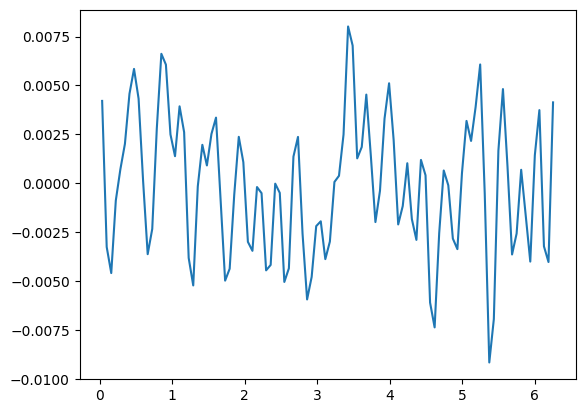

In [25]:
plt.plot(threepcf.phi, threepcf.npcf[0,0,11,4])

In [61]:
threepcf.spins

array([2, 2, 2], dtype=int32)

In [74]:
weight = np.zeros(3)
kwargs = {"k1":None, "k2":[weight,weight,weight]}
ntracers = 3
for key in kwargs.keys():
    if kwargs[key] is None:
        kwargs[key] = [None]*ntracers
    else:
        assert(len(kwargs[key][0])==len(weight))
    print(key, kwargs[key])
    
    

k1 None
k1 [None, None, None]
k2 [array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.])]
k2 [array([0., 0., 0.]), array([0., 0., 0.]), array([0., 0., 0.])]


In [100]:
class Parent:
    
    def __init__(self, a, b):
        self.a = a
        self.b = b
    
    def _func(self, Child, d):
        return self.a + self.b + Child.c + d
    

class Child(Parent):
    
    def __init__(self, a, b, c):
        super().__init__(a, b)
        self.c = c
        
    def func(self, d, e):
        return self._func(self, d) + e
        
child = Child(1,2,3)
child.func(4, 5)

15

In [114]:
def funca(a, b, c):
    return a+b+c

def funcb(a, b, c, d):
    return a+b+c+d

func = funca
args = ()
args += (1,)
args += (2,)
args += (3,)
func(*args)

args = ()
args += (np.ones(10),)
args += (2*np.ones(10),)
args += (3*np.ones(10),)
func(*args).astype(np.complex).dtype

/tmp/ipykernel_166659/1733296993.py:18: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  func(*args).astype(np.complex).dtype


dtype('complex128')

In [14]:
threepcf.clib.__dir__()

['_name',
 '_FuncPtr',
 '_handle',
 'alloc_Gammans_discrete_ggg',
 '__module__',
 '__doc__',
 '_func_flags_',
 '_func_restype_',
 '__init__',
 '__repr__',
 '__getattr__',
 '__getitem__',
 '__dict__',
 '__weakref__',
 '__new__',
 '__hash__',
 '__str__',
 '__getattribute__',
 '__setattr__',
 '__delattr__',
 '__lt__',
 '__le__',
 '__eq__',
 '__ne__',
 '__gt__',
 '__ge__',
 '__reduce_ex__',
 '__reduce__',
 '__subclasshook__',
 '__init_subclass__',
 '__format__',
 '__sizeof__',
 '__dir__',
 '__class__']

In [21]:
a = 1
type(np.int32(a))

numpy.int32

In [64]:
someargs = (1, 2, np.linspace(1,2,3))
allargs = (0, *someargs, np.zeros(2))

In [65]:
allargs

(0, 1, 2, array([1. , 1.5, 2. ]), array([0., 0.]))

In [23]:
arr1 = np.zeros((4,3,5))
arr2 = np.zeros(3)
arr1[:,:,0] *= arr2[np.newaxis,:]

In [32]:
threepcf.__class__.__name__

'GGGCorrelation'

In [4]:
data


In [5]:
slicsfullreso = orpheus.SpinTracerCatalog(spin=2, pos1=pos1, pos2=pos2, tracer_1=gamma1, tracer_2=gamma2, zbins=zphot)

In [58]:
n_cfs = 4
min_sep = 0.5
max_sep_disc = 5.
max_seps = [10.,20.,40.,80.,160.]
dpixs = [0.25,0.5,1.0,2.0,4.0]
binsize=.15
threepcfs = [None]*6
cats = [None]*6
cats[0] = orpheus.SpinTracerCatalog(spin=2, pos1=pos1, pos2=pos2, tracer_1=gamma1, tracer_2=-gamma2, zbins=None)
threepcfs[0] = orpheus.GGGCorrelation(n_cfs, min_sep, max_sep_disc, binsize=binsize, method="Discrete")
threepcfs[0].process(cats[0], nthreads=16)
threepcfs[0].multipoles2npcf()
for elsep, maxsep in enumerate(max_seps):
    print(elsep)
    cats[elsep+1] = cats[0].reduce(dpixs[elsep], ret_inst=True)
    threepcfs[elsep+1] = orpheus.GGGCorrelation(n_cfs, min_sep, max_seps[elsep], binsize=binsize, method="Discrete")
    threepcfs[elsep+1].process(cats[elsep+1], nthreads=16)
    threepcfs[elsep+1].multipoles2npcf()
    #plt.plot(threepcf.bin_centers[0], threepcf.bin_centers[0]*np.diag(threepcf.npcf[0,0,...,15]), label=elcat)
#plt.show()

[2 2 2]
Do we add
We add
1.0337681e-05 4.8615038e-05 599.99976 599.99988
-0.999989662319 -0.999951384962 600.99976 600.99988
601 601 1.0016634769755723 1.0016636129533476
0
[2 2 2]
Do we add
We add
1.0337681e-05 4.8615038e-05 599.99976 599.99988
-0.999989662319 -0.999951384962 600.99976 600.99988
601 601 1.0016634769755723 1.0016636129533476
1
[2 2 2]
Do we add
We add
1.0337681e-05 0.00024391338 599.99664 599.99756
-1.999989662319 -1.99975608662 601.99664 601.9975599999999
301 301 2.006633321137272 2.0066356016166775
2
[2 2 2]
Do we add
We add
0.19420601420000003 0.09920596979999999 599.7801175 599.814356
-3.8057939858 -3.9007940302 603.7801175 603.814356
151 151 4.023747758184106 4.024603642584106
3
[2 2 2]
Do we add
We add
0.6596817388529413 0.6683158212571428 599.2790366666666 599.2762194871794
-7.3403182611470585 -7.331684178742857 607.2790366666666 607.2762194871794
76 76 8.08709677536597 8.086946100867399


/cosma7/data/dp004/dc-port3/miniconda3/envs/3PointEnv/lib/python3.10/site-packages/orpheus/npcf.py:290: RuntimeWarning: divide by zero encountered in true_divide
  self.npcf[elm,...,elphi] = tmp/N0.real
/cosma7/data/dp004/dc-port3/miniconda3/envs/3PointEnv/lib/python3.10/site-packages/orpheus/npcf.py:290: RuntimeWarning: invalid value encountered in true_divide
  self.npcf[elm,...,elphi] = tmp/N0.real


4
[2 2 2]
Do we add
We add
1.72225373948062 1.6784671895848 598.232623442623 598.3188340476191
-14.277746260519379 -14.3215328104152 614.232623442623 614.3188340476191
39 39 16.11565050520878 16.118983765590624


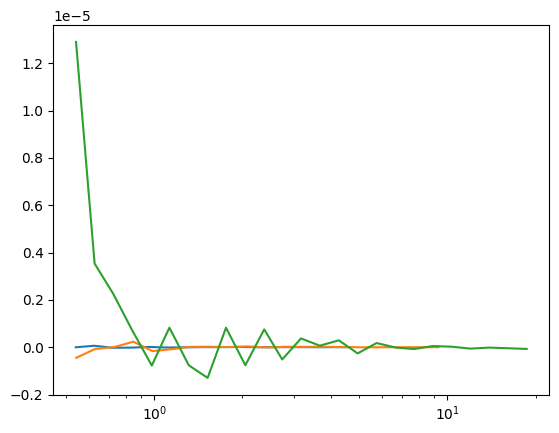

In [68]:
for i in range(3):
    plt.semilogx(threepcfs[i].bin_centers[0], np.diag(threepcfs[i].npcf[0,0,...,15]))

/tmp/ipykernel_201920/3721932938.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(threepcfs[5].npcf_multipoles_norm[0,0].real))


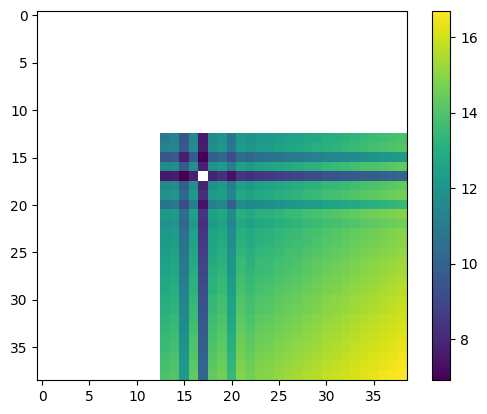

In [83]:
plt.imshow(np.log10(threepcfs[5].npcf_multipoles_norm[0,0].real))
plt.colorbar()

/tmp/ipykernel_201920/821645978.py:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(threepcfs[2].npcf_multipoles[0,0,0].real))


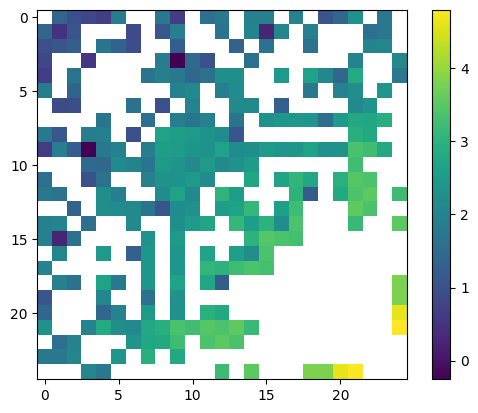

In [108]:
plt.imshow(np.log10(threepcfs[2].npcf_multipoles[0,0,0].real))
plt.colorbar()

In [96]:
import fftnpcf

In [134]:
fftnpcfcat = fftnpcf.PolarCatalog(pos1=slicsfullreso.pos1[::10], pos2=slicsfullreso.pos2[::10],
                                  e1=slicsfullreso.tracer_1[::10], e2=slicsfullreso.tracer_2[::10], 
                                  weight=np.ones(len(slicsfullreso.tracer_2[::10])))

In [136]:
%%time
fftnpcfcat.build_pixeltable_c()
fftres = fftnpcfcat.get_Gammans_discrete(nmax=30,rmin=0.5,rmax=50.,nbinsr=20,nthreads=16)

0.00030817464 0.00094911078 599.99701 599.99768
-0.99969182536 -0.99905088922 600.99701 600.99768
601 601 1.0016584056994342 1.0016584540586022
CPU times: user 25min 36s, sys: 1.41 s, total: 25min 38s
Wall time: 1min 42s


In [142]:
bin_edges_fft, bin_centers_fft, threepcfs_n_fft, threepcfsnorm_n_fft = fftres

/tmp/ipykernel_201920/4195049530.py:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(threepcfs_n_fft[2,10,0].real/threepcfsdisc.npcf_multipoles[2,10,0].real))


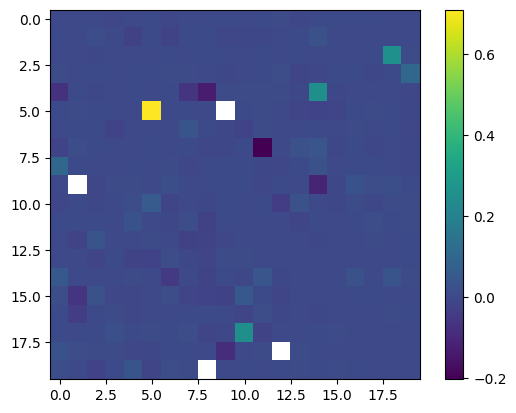

In [147]:
plt.imshow(np.log10(threepcfs_n_fft[2,10,0].real/threepcfsdisc.npcf_multipoles[2,10,0].real))
plt.colorbar()

[2 2 2]
Do we add
We add
0.00030817464 0.00094911078 599.99701 599.99768
-4.99969182536 -4.99905088922 604.99701 604.99768
121 121 5.041295056407934 5.041295296605123
CPU times: user 25min 30s, sys: 1.81 s, total: 25min 31s
Wall time: 1min 44s


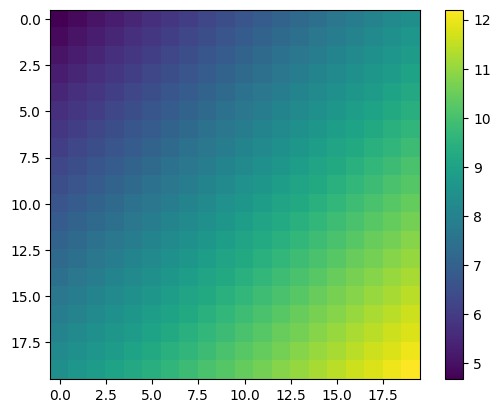

In [171]:
plt.imshow(np.log10(np.abs(threepcfsdisc.npcf_multipoles_norm[0,0].real)))
plt.colorbar()

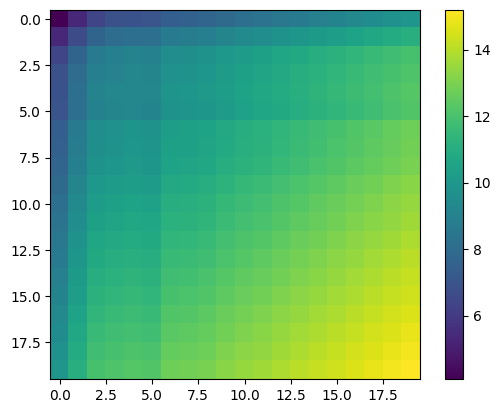

In [172]:
plt.imshow(np.log10(np.abs(threepcf_d1p0.npcf_multipoles_norm[0,0].real)))
plt.colorbar()

In [2]:
data = Table.read("/cosma7/data/dp004/dc-port3/Data/SLICS/KiDS450/GalCatalog_LOS1.fits")
pos1 = data["x_arcmin"].data
pos2 = data["y_arcmin"].data
gamma1 = data["shear1"].data
gamma2 = data["shear2"].data
e1 = data["eps_obs1"].data
e2 = data["eps_obs2"].data
zspec = data["z_spectroscopic"].data
zphot = data["z_photometric"].data

In [3]:
slicsfullreso = orpheus.SpinTracerCatalog(spin=2, pos1=pos1, pos2=pos2, tracer_1=gamma1, tracer_2=gamma2, zbins=None)

In [30]:
%%time
threepcf_full = orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=8., nbinsr=20, method="Discrete")
threepcf_full.process(slicsfullreso, nthreads=16)
threepcf_full.multipoles2npcf()

[2 2 2]
CPU times: user 1h 34min 11s, sys: 5.39 s, total: 1h 34min 17s
Wall time: 6min 3s


In [31]:
%%time
slics_d0p25 = slicsfullreso.reduce(0.25, ret_inst=True)
#slics_d0p25.tracer_1 *= np.sum(slics_d0p25.weight*slics_d0p25.tracer_1)/np.sum(slicsfullreso.weight*slicsfullreso.tracer_1)
#slics_d0p25.tracer_2 *= np.sum(slics_d0p25.weight*slics_d0p25.tracer_2)/np.sum(slicsfullreso.weight*slicsfullreso.tracer_2)
threepcf_d0p25 = orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=16., nbinsr=25, method="Discrete")
threepcf_d0p25.process(slics_d0p25, nthreads=16)
threepcf_d0p25.multipoles2npcf()

[2 2 2]
1.0337681e-05 4.8615038e-05 599.99976 599.99988
-0.999989662319 -0.999951384962 600.99976 600.99988
601 601 1.0016634769755723 1.0016636129533476
CPU times: user 2h 41min 39s, sys: 3.77 s, total: 2h 41min 43s
Wall time: 10min 33s


In [32]:
%%time
slics_d0p5 = slicsfullreso.reduce(0.5, ret_inst=True)
threepcf_d0p5 = orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=32., nbinsr=30, method="Discrete")
threepcf_d0p5.process(slics_d0p5, nthreads=16)
threepcf_d0p5.multipoles2npcf()

[2 2 2]
1.0337681e-05 0.00024391338 599.99664 599.99756
-2.999989662319 -2.99975608662 602.99664 602.99756
201 201 3.014908605285169 3.014912020331443
CPU times: user 2h 52min 49s, sys: 2.87 s, total: 2h 52min 52s
Wall time: 11min 25s


In [33]:
%%time
slics_d1p0 = slicsfullreso.reduce(1., ret_inst=True)
threepcf_d1p0 = orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=64., nbinsr=35, method="Discrete")
threepcf_d1p0.process(slics_d1p0, nthreads=16)
threepcf_d1p0.multipoles2npcf()

[2 2 2]
0.19420601420000003 0.09920596979999999 599.7801175 599.814356
-5.8057939858 -5.9007940302 605.7801175 605.814356
101 101 6.055306054314852 6.056585643863366
CPU times: user 54min 41s, sys: 1.89 s, total: 54min 43s
Wall time: 3min 44s


In [34]:
%%time
slics_d2p0 = slicsfullreso.reduce(2., ret_inst=True)
threepcf_d2p0 = orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=128., nbinsr=40, method="Discrete")
threepcf_d2p0.process(slics_d2p0, nthreads=16)
threepcf_d2p0.multipoles2npcf()

[2 2 2]
0.6596817388529413 0.6683158212571428 599.2790366666666 599.2762194871794
-11.34031826114706 -11.331684178742858 611.2790366666666 611.2762194871794
51 51 12.208222645643405 12.207998111096517
0 [1 1 1 ... 1 1 1]
int32 <class 'numpy.ctypeslib.ndpointer_<i4_C_CONTIGUOUS'>
1 [31. 45. 31. ... 40. 30. 29.]
float64 <class 'numpy.ctypeslib.ndpointer_<f8_C_CONTIGUOUS'>
2 [  1.03515269   0.96697369   1.11144583 ... 598.966434   599.139498
 599.14679966]
float64 <class 'numpy.ctypeslib.ndpointer_<f8_C_CONTIGUOUS'>
3 [  1.12323301   3.05732211   4.9940349  ... 594.91386    596.8583
 599.09769897]
float64 <class 'numpy.ctypeslib.ndpointer_<f8_C_CONTIGUOUS'>
4 [-0.00678948 -0.00799814 -0.01318982 ...  0.00465612 -0.00295668
  0.0032764 ]
float64 <class 'numpy.ctypeslib.ndpointer_<f8_C_CONTIGUOUS'>
5 [ 0.0116347   0.01491831  0.00308049 ...  0.00285059 -0.01024731
 -0.01549553]
float64 <class 'numpy.ctypeslib.ndpointer_<f8_C_CONTIGUOUS'>
6 [0 0 0 ... 0 0 0]
int32 <class 'numpy.ctypeslib.ndp

/cosma7/data/dp004/dc-port3/miniconda3/envs/3PointEnv/lib/python3.10/site-packages/orpheus/npcf.py:324: RuntimeWarning: divide by zero encountered in true_divide
  self.npcf[elm,...,elphi] = tmp/N0.real
/cosma7/data/dp004/dc-port3/miniconda3/envs/3PointEnv/lib/python3.10/site-packages/orpheus/npcf.py:324: RuntimeWarning: invalid value encountered in true_divide
  self.npcf[elm,...,elphi] = tmp/N0.real


CPU times: user 12min 23s, sys: 613 ms, total: 12min 24s
Wall time: 55.4 s


In [35]:
%%time
slics_d4p0 = slicsfullreso.reduce(4., ret_inst=True)
threepcf_d4p0 = orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=256., nbinsr=45, method="Discrete")
threepcf_d4p0.process(slics_d4p0, nthreads=16)
threepcf_d4p0.multipoles2npcf()

[2 2 2]
1.72225373948062 1.6784671895848 598.232623442623 598.3188340476191
-23.27774626051938 -23.3215328104152 623.232623442623 623.3188340476191
25 25 25.860414788125695 25.865614674321375
CPU times: user 3min 8s, sys: 529 ms, total: 3min 9s
Wall time: 15.7 s


178.20000000000002


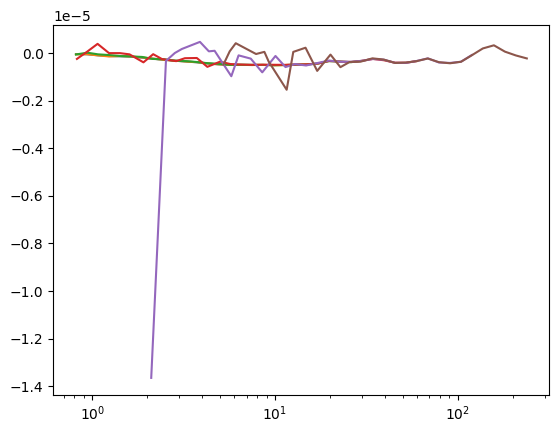

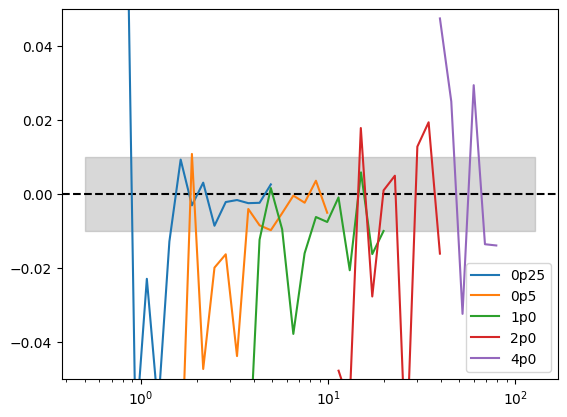

In [137]:
elcomp = 0
elphi = 49
cutlevel = 0.075
kdiag = 3
print(threepcf_d1p0.phi[elphi]*180/np.pi)

plt.semilogx(threepcf_full.bin_centers[0,kdiag:], threepcf_full.bin_centers[0,kdiag:]*np.diag(threepcf_full.npcf[elcomp,0,...,elphi],k=kdiag))
plt.semilogx(threepcf_d0p25.bin_centers[0,kdiag:], threepcf_d0p25.bin_centers[0,kdiag:]*np.diag(threepcf_d0p25.npcf[elcomp,0,...,elphi],k=kdiag))
plt.semilogx(threepcf_d0p5.bin_centers[0,kdiag:], threepcf_d0p5.bin_centers[0,kdiag:]*np.diag(threepcf_d0p5.npcf[elcomp,0,...,elphi],k=kdiag))
plt.semilogx(threepcf_d1p0.bin_centers[0,kdiag:], threepcf_d1p0.bin_centers[0,kdiag:]*np.diag(threepcf_d1p0.npcf[elcomp,0,...,elphi],k=kdiag))
plt.semilogx(threepcf_d2p0.bin_centers[0,kdiag:], threepcf_d2p0.bin_centers[0,kdiag:]*np.diag(threepcf_d2p0.npcf[elcomp,0,...,elphi],k=kdiag))
plt.semilogx(threepcf_d4p0.bin_centers[0,kdiag:], threepcf_d4p0.bin_centers[0,kdiag:]*np.diag(threepcf_d4p0.npcf[elcomp,0,...,elphi],k=kdiag))
plt.show()

plt.axhline(0, color="k", ls="--")
plt.fill_between(x=threepcf_d2p0.bin_edges, y1=-.01, y2=.01, color="grey", alpha=.3)
thisratio = np.diag(threepcf_d0p25.npcf[elcomp,0,...,elphi],k=kdiag)[:-5]/np.diag(threepcf_full.npcf[elcomp,0,...,elphi],k=kdiag)-1
cut = np.argwhere(np.abs(thisratio)>cutlevel)[-1][0]
plt.semilogx(threepcf_full.bin_centers[0][cut:-kdiag], thisratio[cut:], label="0p25")
thisratio = np.diag(threepcf_d0p5.npcf[elcomp,0,...,elphi],k=kdiag)[:-5]/np.diag(threepcf_d0p25.npcf[elcomp,0,...,elphi],k=kdiag)-1
cut = np.argwhere(np.abs(thisratio)>cutlevel)[-1][0]
plt.semilogx(threepcf_d0p25.bin_centers[0][cut:-kdiag], thisratio[cut:], label="0p5")
thisratio = np.diag(threepcf_d1p0.npcf[elcomp,0,...,elphi],k=kdiag)[:-5]/np.diag(threepcf_d0p5.npcf[elcomp,0,...,elphi],k=kdiag)-1
cut = np.argwhere(np.abs(thisratio)>cutlevel)[-1][0]
plt.semilogx(threepcf_d0p5.bin_centers[0][cut:-kdiag], thisratio[cut:], label="1p0")
thisratio = np.diag(threepcf_d2p0.npcf[elcomp,0,...,elphi],k=kdiag)[:-5]/np.diag(threepcf_d1p0.npcf[elcomp,0,...,elphi],k=kdiag)-1
cut = np.argwhere(np.abs(thisratio)>cutlevel)[-1][0]
plt.semilogx(threepcf_d1p0.bin_centers[0][cut:-kdiag], thisratio[cut:], label="2p0")
thisratio = np.diag(threepcf_d4p0.npcf[elcomp,0,...,elphi],k=kdiag)[:-5]/np.diag(threepcf_d2p0.npcf[elcomp,0,...,elphi],k=kdiag)-1
cut = np.argwhere(np.abs(thisratio)>cutlevel)[-1][0]
plt.semilogx(threepcf_d2p0.bin_centers[0][cut:-kdiag], thisratio[cut:], label="4p0")
plt.ylim(-.05,.05)
plt.legend()
plt.show()

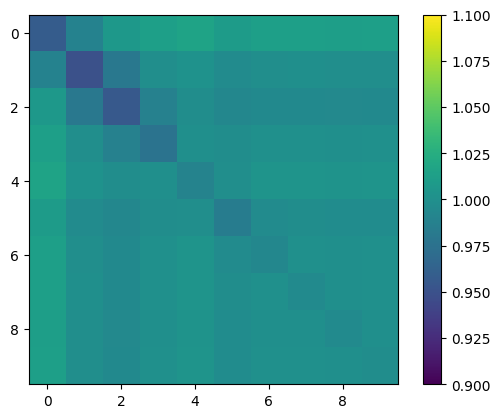

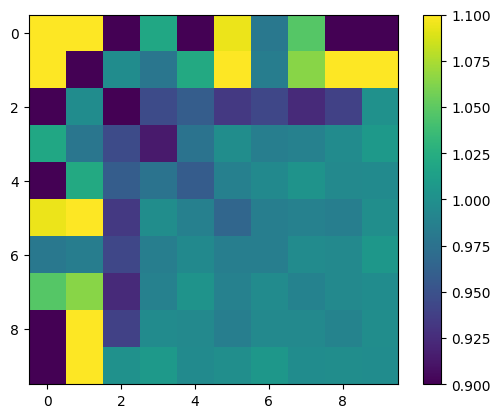

In [10]:
plt.imshow(threepcf_d0p25.npcf_multipoles_norm[0,0][:10,:10].real/threepcf_full.npcf_multipoles_norm[0,0].real,vmin=0.9,vmax=1.1)
plt.colorbar()
plt.show()

plt.imshow(threepcf_d0p25.npcf_multipoles[0,0,0][:10,:10].real/threepcf_full.npcf_multipoles[0,0,0].real,vmin=0.9,vmax=1.1)
plt.colorbar()
plt.show()

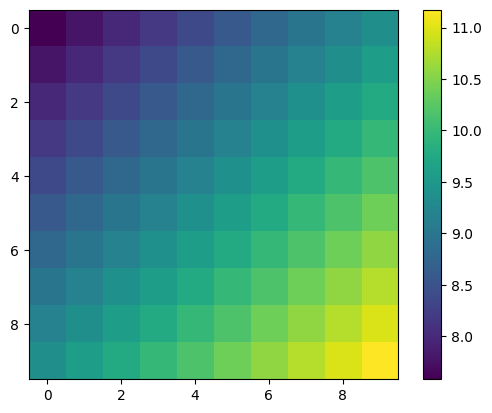

In [89]:
plt.imshow(np.log10(threepcf_full.npcf_multipoles_norm[0,0].real))
plt.colorbar()

In [18]:
threepcf_d4p0.bin_centers[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  3.87103811,  4.09434824,
        5.65846675,  7.83722533,  8.7147298 , 11.8259409 , 13.74058609,
       17.28763266, 22.13302848, 28.2060673 , 35.50357522, 44.8460354 ])

In [25]:
threepcf_d0p5.bin_edges

NameError: name 'threepcf_d0p5' is not defined

In [117]:
np.diag(threepcf_full.npcf[elcomp,0,...,elphi],k=8)

array([6.65885882e-08+5.06402684e-09j, 8.28094830e-08+8.82534972e-09j,
       8.81910696e-08+1.74404298e-08j, 1.05019446e-07+5.01500711e-09j,
       1.04275630e-07+6.79380093e-09j, 1.02444406e-07+6.81097791e-09j,
       1.05478312e-07+5.45027718e-09j, 1.09731088e-07+1.05388800e-08j,
       1.08288919e-07+1.02297665e-08j, 1.04024948e-07+6.82043915e-09j,
       1.01768209e-07+9.47293177e-09j, 9.52020846e-08+7.01741205e-09j])

In [118]:
np.diag(threepcf_d0p25.npcf[elcomp,0,...,elphi],k=8)[:-5]

array([5.17523637e-08+2.37071961e-08j, 6.63002132e-08+1.49515972e-08j,
       1.05063027e-07+2.27903133e-08j, 1.01625817e-07+1.49953592e-08j,
       1.00097690e-07+2.08403715e-09j, 1.00137723e-07+4.74362244e-09j,
       1.05325802e-07+8.81391322e-09j, 1.10152821e-07+1.10315970e-08j,
       1.06804617e-07+9.97286179e-09j, 1.02633002e-07+6.89612705e-09j,
       1.02087210e-07+9.42040109e-09j, 9.46544145e-08+7.01281069e-09j])

In [12]:
np.sum(slicsfullreso.weight)

3070801.0

In [13]:
np.sum(slics_d0p25.weight)

3070801.0

In [154]:
np.sum(slics_d0p25.tracer_2)*3070801.0/2380245

557.4240684339396

In [24]:
np.sum(slicsfullreso.tracer_1)/np.sum(slicsfullreso.weight)

-0.0007747825595844516

In [23]:
np.sum(slics_d0p25.weight*slics_d0p25.tracer_1)/np.sum(slics_d0p25.weight)

-0.0011767495852690948

In [36]:
slicsfullreso.nbinsz

1

In [170]:
dpixs = [0.25,0.5,1.]
slicshash = slicsfullreso.multihash(dpixs=dpixs,tomo=False)

1.0337681e-05 4.8615038e-05 599.99976 599.99988
-1.9999896623189999 -1.9999513849619999 601.99976 601.99988
603 603 1.0016579596390034 1.0016580951657743
0.25 3070801
1.0337681e-05 4.8615038e-05 599.99976 599.99988
-1.9999896623189999 -1.9999513849619999 601.99976 601.99988
603 603 1.0016579596390034 1.0016580951657743
0.5 3070801
1.0337681e-05 0.00024391338 599.99664 599.99756
-1.9999896623189999 -1.9999513849619999 601.99976 601.99988
603 603 1.0016579596390034 1.0016580951657743
1.0 3070801
0.19420601420000003 0.09920596979999999 599.7801175 599.814356
-1.9999896623189999 -1.9999513849619999 601.99976 601.99988
603 603 1.0016579596390034 1.0016580951657743


In [173]:
ngals, pos1s, pos2s, weights, zbins, allfields, index_matchers, pixs_galind_bounds, pix_gals = slicshash

In [152]:
for i in range(4):
    print(len(pos1s[i]), len(pix_gals[i]), len(index_matchers[i]), len(pixs_galind_bounds[i]))

3070801 3070801 363609 3070802
2380245 2380245 363609 2380246
1269041 1269041 363609 1269042
359922 359922 363609 359923


In [162]:
slicsfullreso.pix1_n*slicsfullreso.pix1_n

363609

In [193]:
np.concatenate([allfields[i][0] for i in range(len(allfields))])

array([2.38873890e-06, 9.01606020e-06, 2.93215020e-05, ...,
       6.88890763e-03, 1.91606691e-03, 6.93463917e-03])

In [181]:
allpos1 = np.array([])
for eld in range(len(pos1s)):
    allpos1 = np.append(allpos1, pos1s[eld])
len(allpos1)

7080009

In [186]:
arr1 = np.arange(5)
arr2 = np.arange(4)
arr3 = np.arange(6)
np.concatenate([arr1, arr2, arr3])
#([array1, array2])

array([0, 1, 2, 3, 4, 0, 1, 2, 3, 0, 1, 2, 3, 4, 5])

In [6]:
threepcf_fulltree.tree_redges

array([ 0.5,  5. , 10. , 20. , 40. , 64. ])

In [5]:
threepcf_fulltree.tree_resos

array([0.  , 0.25, 0.5 , 1.  , 2.  ])

In [61]:
#threepcf_fulltree = orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=64., nbinsr=35, method="Tree")
threepcf_fulltree10 = orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=64., nbinsr=35, rmin_pixsize=10, method="Tree")
threepcf_fulltree10.tree_redges

[2 2 2]


array([ 0.5,  2.5,  5. , 10. , 20. , 64. ])

In [ ]:
threepcf_fulltree.process(slicsfullreso, nthreads=16)

1.0337681e-05 4.8615038e-05 599.99976 599.99988
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
0.25 3070801
1.0337681e-05 4.8615038e-05 599.99976 599.99988
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
0.5 3070801
1.0337681e-05 0.00024391338 599.99664 599.99756
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
1.0 3070801
0.19420601420000003 0.09920596979999999 599.7801175 599.814356
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
2.0 3070801
0.6596817388529413 0.6683158212571428 599.2790366666666 599.2762194871794
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732


In [31]:
threepcf_fulltree.multipoles2npcf()

In [62]:
%%time
threepcf_fulltree10.process(slicsfullreso, nthreads=16)
threepcf_fulltree10.multipoles2npcf()

1.0337681e-05 4.8615038e-05 599.99976 599.99988
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
0.25 3070801
1.0337681e-05 4.8615038e-05 599.99976 599.99988
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
0.5 3070801
1.0337681e-05 0.00024391338 599.99664 599.99756
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
1.0 3070801
0.19420601420000003 0.09920596979999999 599.7801175 599.814356
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
2.0 3070801
0.6596817388529413 0.6683158212571428 599.2790366666666 599.2762194871794
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
CPU times: user 4h 59s, sys: 5.15 s, total: 4h 1min 4s
Wall time: 16min 4s


In [81]:
%%time
threepcf_fulltree30 = orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=64., nbinsr=35, rmin_pixsize=30, method="Tree")
threepcf_fulltree30.tree_redges
threepcf_fulltree30.process(slicsfullreso, nthreads=16)
threepcf_fulltree30.multipoles2npcf()

[2 2 2]
1.0337681e-05 4.8615038e-05 599.99976 599.99988
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
0.25 3070801
1.0337681e-05 4.8615038e-05 599.99976 599.99988
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
0.5 3070801
1.0337681e-05 0.00024391338 599.99664 599.99756
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
1.0 3070801
0.19420601420000003 0.09920596979999999 599.7801175 599.814356
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
2.0 3070801
0.6596817388529413 0.6683158212571428 599.2790366666666 599.2762194871794
-3.999989662319 -3.9999513849620003 603.99976 603.9998799999998
303 303 2.0065998338690396 2.006600103580732
CPU times: user 13h 35min 10s, sys: 16 s, total: 13h 35min 26s
Wall time: 54min 9s


In [152]:
print(threepcf_fulltree.tree_redges)
print(threepcf_fulltree.tree_resos)

[ 0.5  5.  10.  20.  40.  64. ]
[0.   0.25 0.5  1.   2.  ]


In [ ]:
%%time
threepcf_fulltree20_dmax4 = orpheus.GGGCorrelation(n_cfs=4, min_sep=0.5, max_sep=64., nbinsr=35, rmin_pixsize=30, method="Tree")
threepcf_fulltree20_dmax4.tree_redges
threepcf_fulltree20_dmax4.process(slicsfullreso, nthreads=16)
threepcf_fulltree20_dmax4.multipoles2npcf()

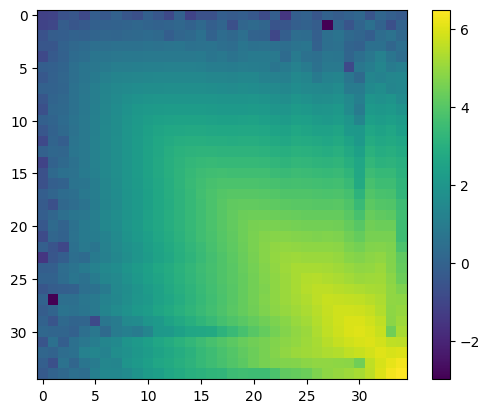

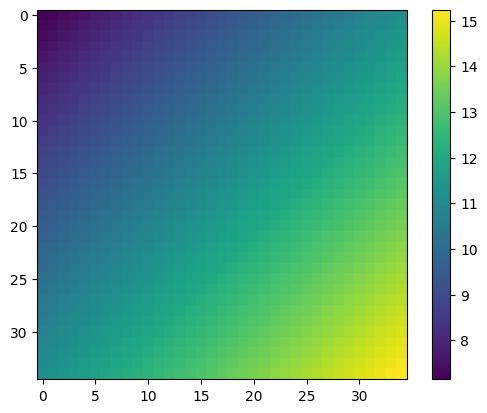

In [30]:
plt.imshow(np.log10(np.abs(threepcf_fulltree.npcf_multipoles[0,0,0].real)))
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.abs(threepcf_fulltree.npcf_multipoles_norm[0,0].real)))
plt.colorbar()
plt.show()

0.5380251177694896 0.5380251177694896 0.016901862493067493 1.8000000000000003


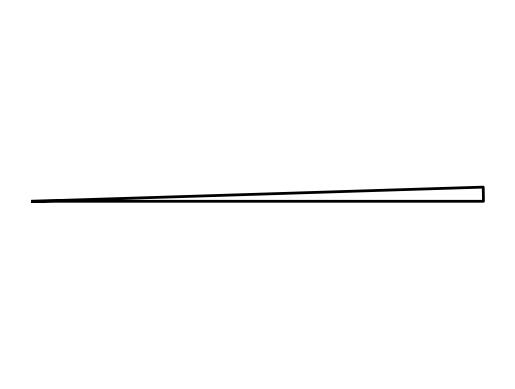

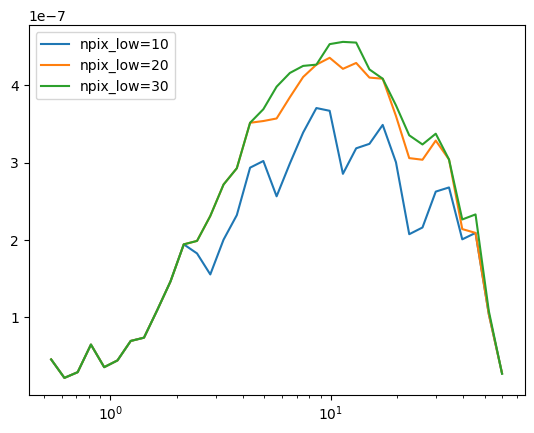

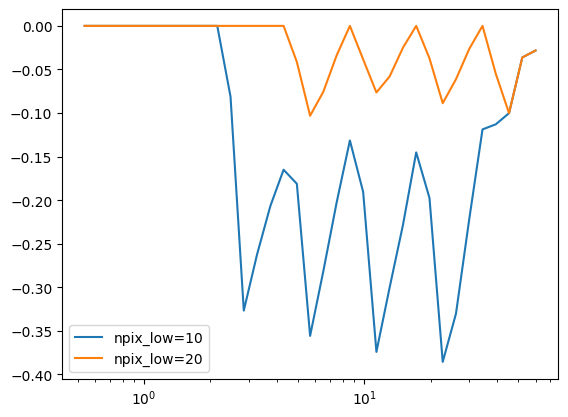

In [148]:
elcomp = 0
elphi = 0
k = 0

side1 = threepcf_fulltree.bin_centers[0][k]
side2 = threepcf_fulltree.bin_centers[0][0]
angle = threepcf_fulltree.phi[elphi]
side3 = np.sqrt(side1**2 + side2**2 - 2 * side1 * side2 * np.cos(angle))
print(side1, side2, side3, angle*180/np.pi)
angle_A = np.degrees(np.arcsin(side1 * np.sin(angle) / side3))
angle_B = np.degrees(np.arcsin(side2 * np.sin(angle) / side3))
A = np.array([0, 0])
B = np.array([side1, 0])
C = np.array([side2 * np.cos(angle), side2 * np.sin(angle)])
plt.plot([A[0], B[0], C[0], A[0]], [A[1], B[1], C[1], A[1]], 'k-', linewidth=2)  # Triangle sides
plt.axis('equal')
plt.axis("off")
plt.show()

_centers = threepcf_fulltree.bin_centers[0][k:]
plt.semilogx(_centers, _centers*np.diag(threepcf_fulltree10.npcf[elcomp,0,...,elphi],k=k), label="npix_low=10")
plt.semilogx(_centers, _centers*np.diag(threepcf_fulltree.npcf[elcomp,0,...,elphi],k=k), label="npix_low=20")
plt.semilogx(_centers, _centers*np.diag(threepcf_fulltree30.npcf[elcomp,0,...,elphi],k=k), label="npix_low=30")
plt.legend()
plt.show()

plt.semilogx(_centers, np.diag((threepcf_fulltree10.npcf/threepcf_fulltree30.npcf)[elcomp,0,...,elphi],k=k)-1, label="npix_low=10")
plt.semilogx(_centers, np.diag((threepcf_fulltree.npcf/threepcf_fulltree30.npcf)[elcomp,0,...,elphi],k=k)-1, label="npix_low=20")
plt.legend()
plt.show()